In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import reg_utils

In [2]:
def load_2D_dataset(is_plot=True):
    data = sio.loadmat('datasets/data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T
    train_Y = np.squeeze(train_Y)
    if is_plot:
        plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, s=40, cmap=plt.cm.Spectral);
    
    return train_X, train_Y, test_X, test_Y

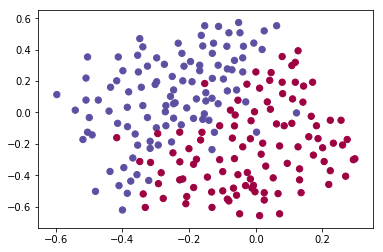

In [3]:
train_X, train_Y, test_X, test_Y = load_2D_dataset(is_plot = True)

In [4]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, isPlot = True, lambd = 0, keep_prob = 1):
    '''
    三层网络 relu relu sigmoid
    
    param:
    X:输入数据
    Y:标签
    learning_rate:学习率α
    num_iterations:迭代次数
    print_cost:是否打印成本每1000次
    isPlot:是否画图
    lambd:正则化的超参数，实数
    keep_prob:随机删除节点的概率
    
    return:
    params:训练后的参数
    '''
    grads = {}
    costs = []
    m = X.shape[1]
    layer_dims = [X.shape[0], 20 , 3, 1]
    
    #初始化参数
    params = reg_utils.initialize_parameters(layer_dims)
    
    #开始学习
    for i in range(0, num_iterations):
        #前向传播
        #是否删除随机节点
        if keep_prob == 1:#不进行随机节点删除
            a3, cache = reg_utils.forward_propagation(X, params)
        elif keep_prob < 1:#随即删除节点
            a3, cache = forward_propagation_with_dropout(X, params, keep_prob)
        else:
            print('keep_prob error!')
            exit
        
        #计算成本
        #是否使用L2范数
        if lambd == 0:#不使用L2范数
            cost = reg_utils.compute_cost(a3, Y)
        else:#使用L2范数
            cost = compute_cost_with_regularization(a3, Y, params, lambd)
            
        #反向传播
        #断言同时只进行dropout或者L2(仅供本次试验)
        assert lambd == 0 or keep_prob == 1
        
        if lambd == 0 and keep_prob == 1:#dropout和L2都不使用
            grads = reg_utils.backward_propagation(X, Y, cache)
        elif lambd != 0:#只用L2
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:#只用dropout
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        #更新参数
        params = reg_utils.update_parameters(params, grads, learning_rate)
        
        if i % 1000 == 0:
            costs.append(cost)
            if print_cost:
                print('第' + str(i) + "次迭代，成本为：" + str(cost))
        
    if isPlot:
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title('Learning rate =' + str(learning_rate))
        plt.show()
    
    return params

第0次迭代，成本为：0.6557412523481002
第1000次迭代，成本为：0.2222669386845115
第2000次迭代，成本为：0.20288702607598855
第3000次迭代，成本为：0.1825149792468696
第4000次迭代，成本为：0.1805397830621775
第5000次迭代，成本为：0.17620471758400452
第6000次迭代，成本为：0.1683273039211542
第7000次迭代，成本为：0.16583593654672973
第8000次迭代，成本为：0.1631267191446051
第9000次迭代，成本为：0.1594261225324511
第10000次迭代，成本为：0.16329987525724213
第11000次迭代，成本为：0.160986144877892
第12000次迭代，成本为：0.15764474148193003
第13000次迭代，成本为：0.15213599644222855
第14000次迭代，成本为：0.14843713518977358
第15000次迭代，成本为：0.14796400922574227
第16000次迭代，成本为：0.14634876306350045
第17000次迭代，成本为：0.1463437586307734
第18000次迭代，成本为：0.1433508853738184
第19000次迭代，成本为：0.13936488362309993
第20000次迭代，成本为：0.13851642423265018
第21000次迭代，成本为：0.1411867835180781
第22000次迭代，成本为：0.13629319468821335
第23000次迭代，成本为：0.13151860137538526
第24000次迭代，成本为：0.13032326002026826
第25000次迭代，成本为：0.13285370211402686
第26000次迭代，成本为：0.1281481286198926
第27000次迭代，成本为：0.13263846518815608
第28000次迭代，成本为：0.12678384582902597
第29000次迭代，成本为：0.12408776090911468


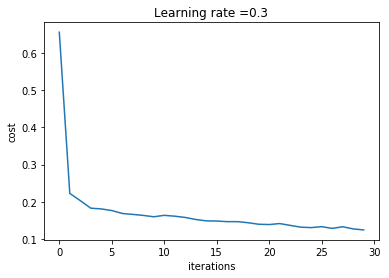

训练集
Accuracy: 0.9478672985781991
测试集
Accuracy: 0.915


In [5]:
train_Y = train_Y.reshape(1,train_Y.shape[0])
params = model(train_X, train_Y, isPlot = True)
print("训练集")
pred_train = reg_utils.predict(train_X, train_Y, params)
print("测试集")
pred_test  = reg_utils.predict(test_X, test_Y, params)

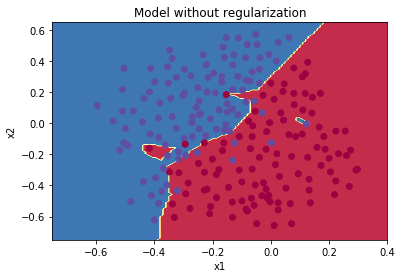

In [6]:
train_Y = np.squeeze(train_Y)
plt.title('Model without regularization')
axes = plt.gca()
axes.set_xlim([-0.75, 0.40])
axes.set_ylim([-0.75, 0.65])
reg_utils.plot_decision_boundary(lambda x : reg_utils.predict_dec(params, x.T), train_X, train_Y)

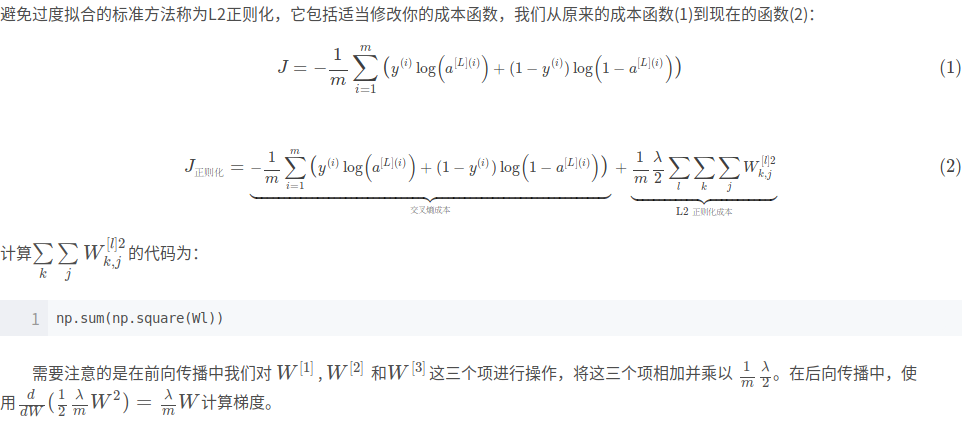

In [7]:
def compute_cost_with_regularization(A3, Y, params, lambd):
    '''
    实现公式2计算J正则化
    param:
    A3:最后一次正向传播激活后的值
    Y:标签
    params:w和b的字典
    lambd:L2系数
    
    return:
    cost:使用公式2计算的成本
    '''
    m = Y.shape[1]
    W1 = params['W1']
    W2 = params['W2']
    W3 = params['W3']
    
    cross_entropy_cost = reg_utils.compute_cost(A3, Y)
    
    L2_regular_cost = lambd * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3))) / (2 * m)
    
    cost = cross_entropy_cost + L2_regular_cost
    
    return cost

In [8]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    '''
    param:
    X:输入数据
    Y:标签
    cache:前向传播的缓存
    lambd:L2超参数系数
    
    return:
    grads:导数值字典
    '''
    m = Y.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = (1 / m) * np.dot(dZ3, A2.T) + ((lambd * W3) / m)
    db3 = (1 / m) * np.sum(dZ3, axis = 1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = (1 / m) * np.dot(dZ2, A1.T) + ((lambd * W2) / m)
    db2 = (1 / m) * np.sum(dZ2, axis = 1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = (1 / m) * np.dot(dZ1, X.T) + ((lambd * W1) / m)
    db1 = (1 / m) * np.sum(dZ1, axis = 1, keepdims = True)
    
    grads = {'dZ3' : dZ3, 'dW3' : dW3, 'db3' : db3, 'dA2' : dA2, 
             'dZ2' : dZ2, 'dW2' : dW2, 'db2' : db2, 'dA1' : dA1,
             'dZ1' : dZ1, 'dW1' : dW1, 'db1' : db1}
    
    return grads

In [9]:
print(train_Y.shape)
train_Y = train_Y.reshape(1, train_Y.shape[0])
print(train_Y.shape)

(211,)
(1, 211)


第0次迭代，成本为：0.6974484493131264
第1000次迭代，成本为：0.27304563479326766
第2000次迭代，成本为：0.26985760798332925
第3000次迭代，成本为：0.269508280641266
第4000次迭代，成本为：0.2692654449361621
第5000次迭代，成本为：0.26904304743497043
第6000次迭代，成本为：0.26889745607345616
第7000次迭代，成本为：0.2687751717855725
第8000次迭代，成本为：0.26867325020602606
第9000次迭代，成本为：0.2685595174585009
第10000次迭代，成本为：0.2684918873282239
第11000次迭代，成本为：0.2684141282822975
第12000次迭代，成本为：0.268370115369031
第13000次迭代，成本为：0.2683177401855035
第14000次迭代，成本为：0.26826704893477976
第15000次迭代，成本为：0.2682199033729047
第16000次迭代，成本为：0.26816870547972715
第17000次迭代，成本为：0.2681517100224051
第18000次迭代，成本为：0.2681331699914916
第19000次迭代，成本为：0.2680892379993575
第20000次迭代，成本为：0.2680916337127301
第21000次迭代，成本为：0.26803821899502356
第22000次迭代，成本为：0.2680604579764401
第23000次迭代，成本为：0.26782909050763876
第24000次迭代，成本为：0.2678953595054706
第25000次迭代，成本为：0.2679428566388702
第26000次迭代，成本为：0.26785446611618824
第27000次迭代，成本为：0.2679162550106563
第28000次迭代，成本为：0.26789526792627955
第29000次迭代，成本为：0.2678261099093218


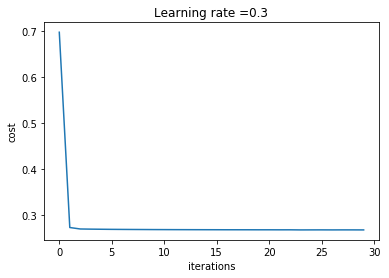

In [10]:
params = model(train_X, train_Y, lambd = 0.7, isPlot = True)

In [11]:
print('正则化训练集：')
pred_train = reg_utils.predict(train_X, train_Y, params)
print('正则化测试集：')
pred_test = reg_utils.predict(test_X, test_Y, params)

正则化训练集：
Accuracy: 0.9383886255924171
正则化测试集：
Accuracy: 0.93


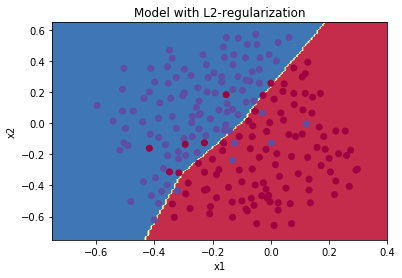

In [12]:
train_Y = np.squeeze(train_Y)
plt.title('Model with L2-regularization')
axes = plt.gca()
axes.set_xlim([-0.75, 0.40])
axes.set_ylim([-0.75, 0.65])
reg_utils.plot_decision_boundary(lambda x : reg_utils.predict_dec(params, x.T), train_X, train_Y)

可以看到所谓L2正则化就是减小了训练集的过拟合程度，lambd参数可以让决策边界更加平滑，当然如果参数过大会导致过度平滑从而加大偏差。     
L2正则化依赖于假设”较小权重的模型比较大权重的模型更简单“，因此通过削减成本函数中权重的平方值，即乘lambd(lambd < 1)来将权重逐渐变小。   
L2正则化的影响：    
1.成本计算花费更多    
2.反向传播的花费更多   
3.权重衰减，权重被逐渐改变的较小的范围

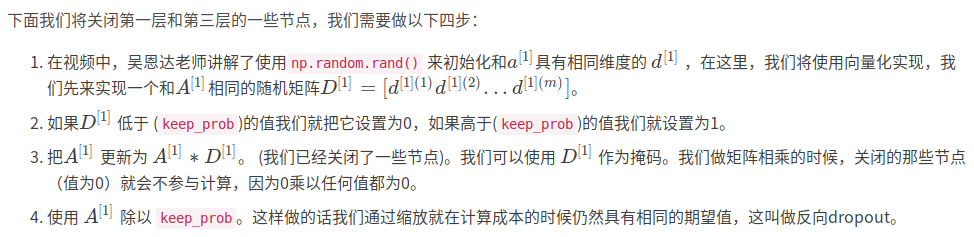

In [13]:
def forward_propagation_with_dropout(X,parameters,keep_prob=0.5):
    """
    实现具有随机舍弃节点的前向传播。
    LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.

    参数：
        X  - 输入数据集，维度为（2，示例数）
        parameters - 包含参数“W1”，“b1”，“W2”，“b2”，“W3”，“b3”的python字典：
            W1  - 权重矩阵，维度为（20,2）
            b1  - 偏向量，维度为（20,1）
            W2  - 权重矩阵，维度为（3,20）
            b2  - 偏向量，维度为（3,1）
            W3  - 权重矩阵，维度为（1,3）
            b3  - 偏向量，维度为（1,1）
        keep_prob  - 随机删除的概率，实数
    返回：
        A3  - 最后的激活值，维度为（1,1），正向传播的输出
        cache - 存储了一些用于计算反向传播的数值的元组
    """
    np.random.seed(1)

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]

    #LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1,X) + b1
    A1 = reg_utils.relu(Z1)

    #下面的步骤1-4对应于上述的步骤1-4。
    D1 = np.random.rand(A1.shape[0],A1.shape[1])    #步骤1：初始化矩阵D1 = np.random.rand(..., ...)
    D1 = D1 < keep_prob                             #步骤2：将D1的值转换为0或1（使用keep_prob作为阈值）
    A1 = A1 * D1                                    #步骤3：舍弃A1的一些节点（将它的值变为0或False）
    A1 = A1 / keep_prob                             #步骤4：缩放未舍弃的节点(不为0)的值
    Z2 = np.dot(W2,A1) + b2
    A2 = reg_utils.relu(Z2)

    #下面的步骤1-4对应于上述的步骤1-4。
    D2 = np.random.rand(A2.shape[0],A2.shape[1])    #步骤1：初始化矩阵D2 = np.random.rand(..., ...)
    D2 = D2 < keep_prob                             #步骤2：将D2的值转换为0或1（使用keep_prob作为阈值）
    A2 = A2 * D2                                    #步骤3：舍弃A1的一些节点（将它的值变为0或False）
    A2 = A2 / keep_prob                             #步骤4：缩放未舍弃的节点(不为0)的值

    Z3 = np.dot(W3, A2) + b3
    A3 = reg_utils.sigmoid(Z3)

    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)

    return A3, cache

In [14]:
def backward_propagation_with_dropout(X,Y,cache,keep_prob):
    """
    实现我们随机删除的模型的后向传播。
    参数：
        X  - 输入数据集，维度为（2，示例数）
        Y  - 标签，维度为（输出节点数量，示例数量）
        cache - 来自forward_propagation_with_dropout（）的cache输出
        keep_prob  - 随机删除的概率，实数

    返回：
        gradients - 一个关于每个参数、激活值和预激活变量的梯度值的字典
    """
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache

    dZ3 = A3 - Y
    dW3 = (1 / m) * np.dot(dZ3,A2.T)
    db3 = 1. / m * np.sum(dZ3, axis=1, keepdims=True)
    dA2 = np.dot(W3.T, dZ3)

    dA2 = dA2 * D2          # 步骤1：使用正向传播期间相同的节点，舍弃那些关闭的节点（因为任何数乘以0或者False都为0或者False）
    dA2 = dA2 / keep_prob   # 步骤2：缩放未舍弃的节点(不为0)的值

    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1. / m * np.dot(dZ2, A1.T)
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.dot(W2.T, dZ2)

    dA1 = dA1 * D1          # 步骤1：使用正向传播期间相同的节点，舍弃那些关闭的节点（因为任何数乘以0或者False都为0或者False）
    dA1 = dA1 / keep_prob   # 步骤2：缩放未舍弃的节点(不为0)的值

    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1. / m * np.dot(dZ1, X.T)
    db1 = 1. / m * np.sum(dZ1, axis=1, keepdims=True)

    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}

    return gradients

第0次迭代，成本为：0.6543912405149825
第1000次迭代，成本为：0.1759784892976791
第2000次迭代，成本为：0.10396707442900774
第3000次迭代，成本为：0.0766129778735777
第4000次迭代，成本为：0.06719891269813578


/home/lhy/DeepLearning/AndrewNg/improveNeuralNetwork/RegularizeNormalizeGradientCheck/reg_utils.py:121: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
/home/lhy/DeepLearning/AndrewNg/improveNeuralNetwork/RegularizeNormalizeGradientCheck/reg_utils.py:121: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


第5000次迭代，成本为：0.06466905008519824
第6000次迭代，成本为：0.062409872596981324
第7000次迭代，成本为：0.06187873531315627
第8000次迭代，成本为：0.0614332181524981
第9000次迭代，成本为：0.061192143757634855
第10000次迭代，成本为：0.06101698657490562
第11000次迭代，成本为：0.06093245082616846
第12000次迭代，成本为：0.060826401965961126
第13000次迭代，成本为：0.0608626412998495
第14000次迭代，成本为：0.060835215370212144
第15000次迭代，成本为：0.06066457216128777
第16000次迭代，成本为：0.06064947237748144
第17000次迭代，成本为：0.06062585662115727
第18000次迭代，成本为：0.06065874505596672
第19000次迭代，成本为：0.06059651330299937
第20000次迭代，成本为：0.060582435798513114
第21000次迭代，成本为：0.060559199380913135
第22000次迭代，成本为：0.060578983901564847
第23000次迭代，成本为：0.060564614663729345
第24000次迭代，成本为：0.06050359026993201
第25000次迭代，成本为：0.06050179002362491
第26000次迭代，成本为：0.06052211741257311
第27000次迭代，成本为：0.06047314739225407
第28000次迭代，成本为：0.06047206692105944
第29000次迭代，成本为：0.060485966719343975


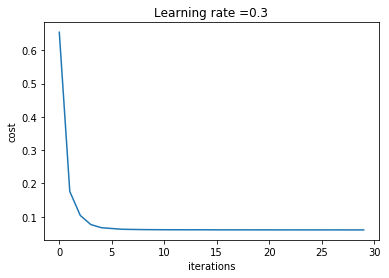

随机删除节点训练集：
Accuracy: 0.9289099526066351
随机删除节点测试集：
Accuracy: 0.95


In [15]:
train_Y = train_Y.reshape(1, train_Y.shape[0])
params = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3, isPlot = True)

print('随机删除节点训练集：')
pred_train = reg_utils.predict(train_X, train_Y, params)
print('随机删除节点测试集：')
pred_test = reg_utils.predict(test_X, test_Y, params)

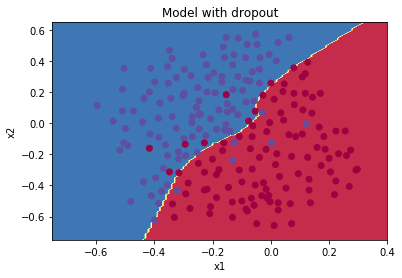

In [17]:
train_Y = np.squeeze(train_Y)
plt.title('Model with dropout')
axes = plt.gca()
axes.set_xlim([-0.75, 0.40])
axes.set_ylim([-0.75, 0.65])
reg_utils.plot_decision_boundary(lambda x : reg_utils.predict_dec(params, x.T), train_X, train_Y)

随机删除节点的正则化方法会降低训练集的准确率，但会提升测试集的准确率，所以适当的使用正则化方法不失为一种降低过拟合，提升准确率的选择。